# Projet Dreem - Notebook Jupiter

#### Auteurs : Aymeric Lechevranton & Benjamin Martineau & Antoine Gauthier

## Introduction

Ce Notebook Jupiter accompagne le rapport du projet Dreem que nous avons rédigé au cours du [Data Challenge 2019](https://challengedata.ens.fr/participants/challenges/10/ "Lien vers Challenge Dreem"). Il permet de mettre en oeuvre les algorithmes présentés et résultats obtenus durant ce rapport. Par l'intermédiaire de ce notebook, nous allons vous exposer notre cheminement à travers l'analyse descriptive des données, l'implémentation d'algorithmes divers (parfois non-mentionné dans le rapport) ainsi que l'analyse et l'ajustement de l'algorithme choisi.

## Partie 1 - Analyse descriptive

Nous importons les données contenues sous un format HDF5 (Hierarchical Data Format).

In [233]:
import h5py
import pandas as pd
import numpy as np

X_train = h5py.File("X_train_KBHhQ0d.h5", "r")
y_data = pd.read_csv("y_train_2.csv").as_matrix()[:, 1].squeeze()
X_test = h5py.File("X_test_eFVIB85.h5", "r")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


La première partie des données est composée d'informations précises sur le sommeil des individus. D'après les diagrammes en boîte, la distribution de ces variables par label est souvent similaire entre les 3 labels et ce pour chaque variable. On peut néanmoins noter que le label 0 se distingue quelques peu des label 1 et 2 par le temps que la personne a passé en sommeil REM jusqu'à présent.

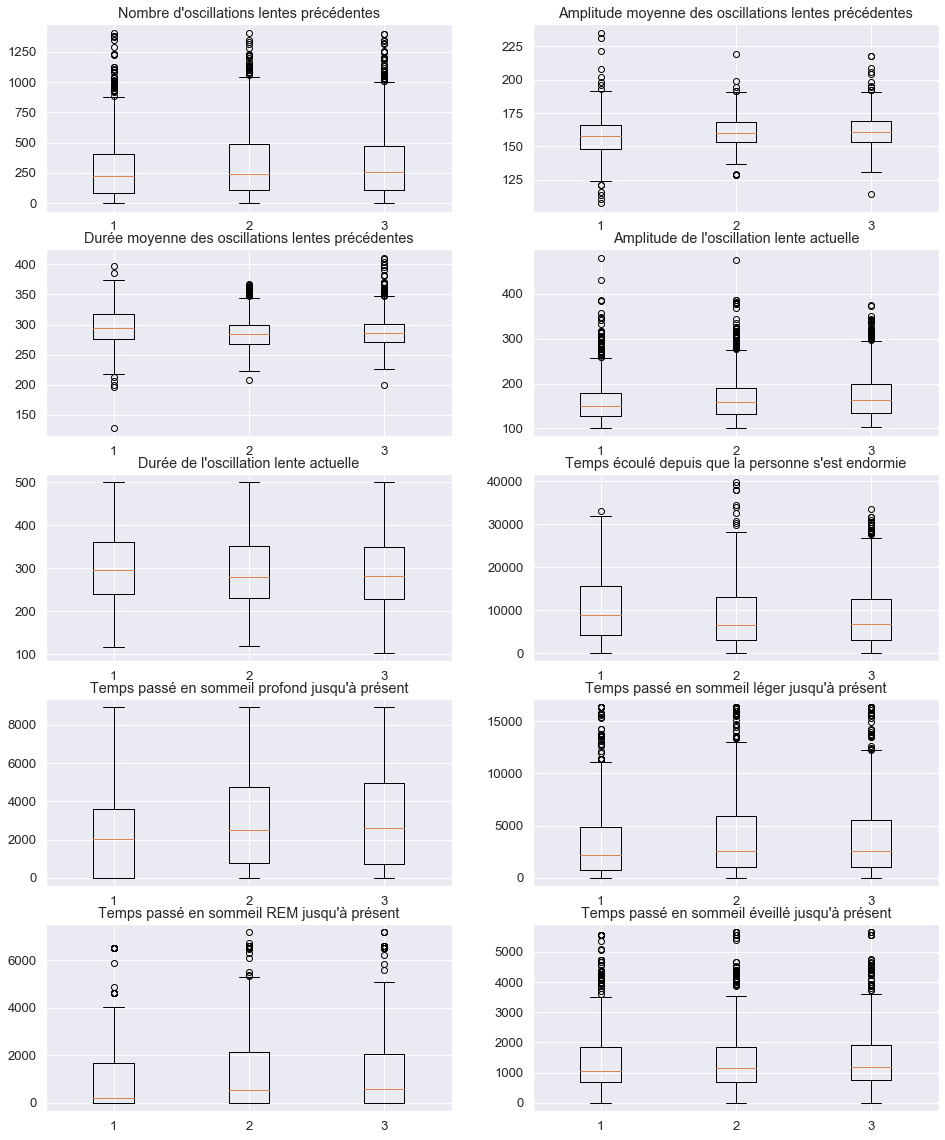

In [45]:
mm = np.delete(X_train["features"][:,:11], [5], axis=1)
ind0 = np.where(y_data==0)[0][:1000]; mean0 = [mm[ind0,i] for i in range(10)]
ind1 = np.where(y_data==1)[0][:1000]; mean1 = [mm[ind1,i] for i in range(10)]
ind2 = np.where(y_data==2)[0][:1000]; mean2 = [mm[ind2,i] for i in range(10)]
ind = [ind0,ind1,ind2]; mean = [mean0,mean1,mean2]
tit = ['Nombre d\'oscillations lentes précédentes', 'Amplitude moyenne des oscillations lentes précédentes',
      'Durée moyenne des oscillations lentes précédentes', 'Amplitude de l\'oscillation lente actuelle',
      'Durée de l\'oscillation lente actuelle', 'Temps écoulé depuis que la personne s\'est endormie',
      'Temps passé en sommeil profond jusqu\'à présent', 'Temps passé en sommeil léger jusqu\'à présent',
      'Temps passé en sommeil REM jusqu\'à présent', 'Temps passé en sommeil éveillé jusqu\'à présent']
fig, ax = plt.subplots(5,2,figsize=(16, 20))
for i in range(5*2):
    plt.subplot(5,2,1+i)
    plt.boxplot([[x for x in mean[0][i]],[x for x in mean[1][i]],[x for x in mean[2][i]]])
    plt.title(tit[i])
plt.show()

Au travers du graphique des corrélations, nous observons que les corrélations entre ces variables sont pratiquement toutes en dessous de 80% et majoritairement comprise entre 0 et 0.4 en valeurs absolue. On observe néanmoins que les variables 6, 7 et 8 sont particulièrement corrélées à la variables 0. Autrement dit, le nombre d'oscillations lentes précédentes est fortement corrélé avec la durée de l'oscillation lente actuelle, le temps écoulé depuis que la personne s'est endormie et le temps passé en sommeil profond jusqu'à présent.

In [98]:
sum(df5==1)[0]

131366

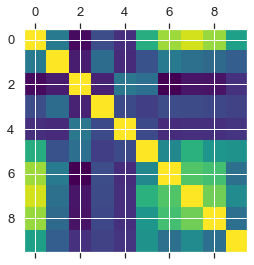

In [123]:
import matplotlib.pyplot as plt
df = pd.DataFrame(np.delete(X_train["features"][:,:11], [5], axis=1))
plt.matshow(df.corr(),cmap='viridis')
plt.show()

Concernant la seule variables qualitative de ce jeu de données, les individus sont équitablement distribués entre les deux états de sommeil possible (étape 2 et 3).


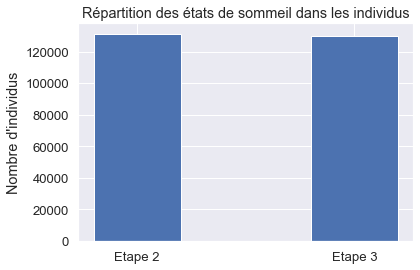

In [135]:
df5 = np.array(pd.get_dummies(X_train["features"][:,5]))[:,0].reshape(-1, 1)
plt.bar([1,2],[sum(df5==1)[0],sum(df5==0)[0]],width=0.4)
plt.xticks([1,2], ('Etape 2','Etape 3'))
plt.ylabel('Nombre d\'individus')
plt.title('Répartition des états de sommeil dans les individus')
plt.show()

La seconde partie des données se compose de 1250 valeurs en microVolt d'un électroencéphalogramme (EEG). Une première observation du EEG nous permet de remarquer qu'il n'y a pas de tendance ou de saisonnalité et ce pour tous les EEG. Par conséquent, tenter une prédiction des faibles oscillations à travers les méthodes de séries temporelles dans le but de prévoir les EEG dans la seconde qui suit semble être inefficace et inadapté pour nos données EEG. Par ailleurs, la répartition des valeurs des EEG ne diffère pas d'un label à l'autre. En d'autre terme, la distribution des EEG ne renseigne pas sur un potentiel élément discriminant entre les labels. Nous pouvons cependant noter qu'il y a un grand nombre de valeurs extrême et ce peu importe le label, en effet, les valeurs sont très concentrées au centre (proche de 0).

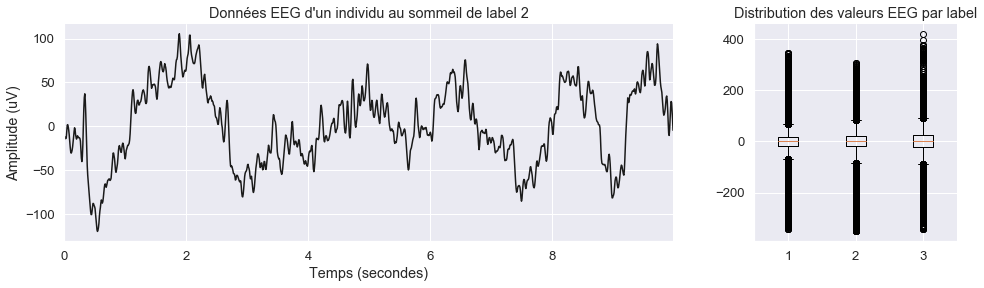

In [234]:
import yasa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mne.filter import filter_data
sns.set(font_scale=1.2)

data = X_train["features"][:,11:] #11:1261

#fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sf = 125.
time = np.arange(data.shape[1]) / sf
fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(16, 4))
plt.subplot(a0)
plt.plot(time, data[4,:], lw=1.5, color='k')
plt.xlabel('Temps (secondes)')
plt.ylabel('Amplitude (uV)')
plt.xlim([time.min(), time.max()])
plt.title('Données EEG d\'un individu au sommeil de label 2')
ind0 = np.where(y_data==0)[0][:1000]; ind1 = np.where(y_data==1)[0][:1000]; ind2 = np.where(y_data==2)[0][:1000]
plt.subplot(a1)
plt.boxplot([[x for x in data[ind0,:].flatten()],[x for x in data[ind1,:].flatten()],[x for x in data[ind2,:].flatten()]])
plt.title('Distribution des valeurs EEG par label')
sns.despine()

Les densités des 3 labels sont très similaires. Nous pouvons néanmoins remarquer que le label 0 (pas de faible oscillation) est plus dense sur 0 ce qui se traduit graphiquement par un pic plus marqué. Les valeurs des EEG pour le label 0 sont donc sensiblement moins variables que pour les labels 1 et 2 (présence de faibles oscillations).

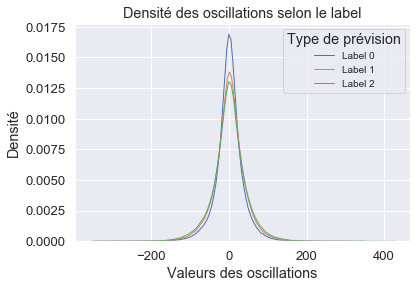

In [235]:
import seaborn
case = ['Label 0','Label 1','Label 2']
mean0=[x for x in data[ind0,:].flatten()];mean1=[x for x in data[ind1,:].flatten()];mean2=[x for x in data[ind2,:].flatten()]
mean = [mean0,mean1,mean2]
for cas in range(3):
    seaborn.distplot(mean[cas], hist=False, kde=True, kde_kws={'linewidth': 1}, label=case[cas])
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Type de prévision')
plt.title('Densité des oscillations selon le label')
plt.xlabel('Valeurs des oscillations')
plt.ylabel('Densité')
plt.show()

Au travers de la méthode IsolationForest, nous détectons les outliers. Cet algorithme cherche à isolé de manière récursive avec une coupure les valeurs. Ainsi, plus une valeurs est loin du reste des données, plus elle est facilement isolable. Les outliers détecté par cette méthode représentent environs 10% du jeu de données ce qui n'est pas négligeable. Cependant, la suppression de ces éléments n'a pas permi d'augmenté notre score.

In [165]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=150,n_jobs=-1)
clf.fit(nmm)
sum(clf.predict(nmm)==1)/len(nmm) # 89.99% bien => 10% d'outliers

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0.8999977067200746

Nous allons maintenant réaliser une analyse en composante principale (ACP) qui nous permettra de mieux apprécier les dynamiques du jeu de données. L'analyse en composante principale montre que 72.8% de la variance est expliqué par les deux premiers axes. Nous allons donc créer une représentation graphique des données basée sur ces 2 premiers axes.

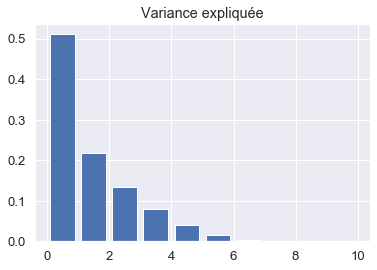

0.7280130074006483


In [236]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
mm = np.delete(X_train["features"][:,:11], [5], axis=1)
nmm = pd.DataFrame(Normalizer().fit(mm).transform(mm))
pca = PCA(n_components=10)
pca.fit(nmm)
#pca.explained_variance_ratio_
#PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,svd_solver='auto', tol=0.0, whiten=False)
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée");
plt.show();print(sum(pca.explained_variance_ratio_[:2]))

Nous créons alors le plan de ces deux axes principaux pour observer l'importance des variables dans sa construction et de ce fait les variables les plus discriminantes au sein du jeu de données. Ainsi, les variables les plus discriminantes sont : la durée de l'oscillation lente actuelle (6), le temps écoulé depuis que la personne s'est endormie (7) et l'amplitude de l'oscillation actuelle (5). Toutefois, les contributions ne sont franches car par exemple la variables 6 est corrélées à 0.2 de l'axe 1.

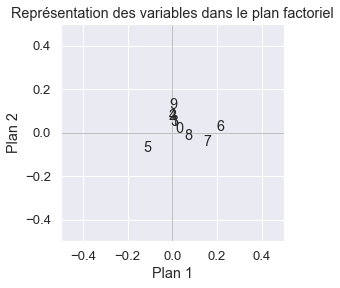

In [298]:
from sklearn.decomposition import PCA
acp = PCA(svd_solver='full')
coord = acp.fit_transform(nmm)
n = nmm.shape[0]
eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
p = nmm.shape[1]
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]
fig, axes = plt.subplots(figsize=(4,4))
axes.set_xlim(-.5,.5)
axes.set_ylim(-.5,.5)
for j in range(p):
    plt.annotate(nmm.columns[j],(corvar[j,0],corvar[j,1]))
plt.plot([-.5,.5],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-.5,.5],color='silver',linestyle='-',linewidth=1)
plt.xlabel('Plan 1')
plt.ylabel('Plan 2')
plt.title('Représentation des variables dans le plan factoriel')
plt.show()

Le plan factoriel ne discrimine pas les données en groupe d'individus distincts. En effet, les 3 labels sont mélangés au sein du nuage de points. En outre, l'analyse en composante principale n'est pas concluente et nous renforce dans la complexité de classement de ces données.

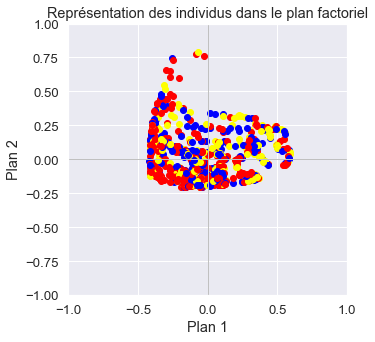

In [296]:
fig, axes = plt.subplots(figsize=(5,5))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
X = nmm.iloc[:1000,:]
n = X.shape[0]
col = ['red','blue','yellow']
for i in range(n):
    plt.scatter(coord[i,0],coord[i,1], c=col[y_data[i]])
plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)
plt.xlabel('Plan 1')
plt.ylabel('Plan 2')
plt.title('Représentation des individus dans le plan factoriel')
plt.show()

## Partie 2 - Création de variables

Pour tirer plus d'informations sur ce jeu de données, nous nous interessons maintenant aux signaux EEG. Nous avons décidé de décomposer les signaux en périodogramme, en puissance de bandes de fréquences et en trouvant les faibles oscillations dans les signaux EEG. Pour cela, nous avons utilisé le package [YASA](https://github.com/raphaelvallat/yasa "Lien vers Github").

In [ ]:
### Calcul de la puissance des bandes
def bandpower(data, sf, band, window_sec=None, relative=False):
    from scipy.signal import welch
    from mne.time_frequency import psd_array_multitaper
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf
    psd, freqs = psd_array_multitaper(data, sf, band[0], band[1],adaptive=True,normalization='full',n_jobs=8)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Approximation d'intégrale du spectre par la méthode de Simpson.
    bp = simps(psd[idx_band], dx=freq_res)
    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

data = X_train["features"][:,11:]

# On récupère les signaux (beta, alpha, theta, delta)
sf = 125.
bd = np.zeros((len(data),5))
for i in range(len(data)):
    bd[i,0] = bandpower(data[i,:], sf, [12, 30])
    bd[i,1] = bandpower(data[i,:], sf, [8, 12])
    bd[i,2] = bandpower(data[i,:], sf, [4, 8])
    bd[i,3] = bandpower(data[i,:], sf, [0.5, 4])
    bd[i,4] = bandpower(data[i,:], sf, [0.001, 0.5])

In [ ]:
### Calcul des dernières faibles oscillations sur l'enregistrement + fréquence moyenne + nombre + durée totale.
import h5py
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from yasa import sw_detect

data = X_train["features"][:,11:]
sf = 125.
res = np.zeros((len(data),13))
for i in range(len(data)):
    sw = sw_detect(data[i,11:], sf)           
    if sw is None or sw.shape[0]==0:
        res[i,:] = [None, None, None, None, None, None, None, None, None, None, None, 0, None]
    else:
        res[i,:10] = np.array(sw)[sw.shape[0]-1,:10]
        res[i,10] = np.mean((np.array(sw)[:,10]))
        res[i,11] = sw.shape[0]
        res[i,12] = np.sum((np.array(sw)[:,5]))


Nous présentons succintement les sorties proposées par la fonction sw_detect qui s'attache à détecter les faibles oscillations dans un signal EEG.

In [ ]:
# Avant start, c'est le numéro de la slow-wave détectée. 
'Start' : Départ de chaque slow-wave détectée (en secondes)
'NegPeak' : Localisation du pic négatif (en secondes)
'MidCrossing' : Localisation du passage à zéros de négatif-positif
'Pospeak' : Localisation du pic négatif (en secondes)
'End' : Fin de la slow-wave (en secondes)
'Duration' : Durée (en secondes)
'ValNegPeak' : Amplitude du pic négatif (en uV)
'ValPosPeak' : Amplitude du pic positif (en uV)
'PTP' : Amplitude de pic à pic (ValPosPeak - ValNegPeak)
'Slope' : Courbe entre NegPeak et MidCrossing (en uV/sec)
'Frequency' : Fréquence de la slow-wave (1 / Durée)

In [10]:
### Calcul du périodogramme par la méthode multitapper
from mne.time_frequency import psd_array_multitaper
sf = 125.
psd_mt, freqs_mt = psd_array_multitaper(data,sf,adaptive=True,normalization='full',n_jobs=8)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.4s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.3s remaining:    0.5s
[Para

Le calcul de ces éléments est particulièrement prenant en terme de calcul. Pour nous éviter le calcul régulier de ces nouvelles variables, vous trouverez en Annexe les fichier .csv de ces variables que nous avons enregistré sous cette forme pour n'avoir qu'à les télécharger. Le principe sera également le même pour les fichiers test.

In [9]:
res = np.loadtxt('last.csv', delimiter=',')
bd = np.loadtxt('bd.csv', delimiter=',')
data = X_train["features"][:,11:]

A partir de ces nouvelles informations et des signaux EEG, nous avons créé les variables suivantes. Presque toute sont en réalité l'analyse descriptive de toute ou partie des signaux.

In [11]:
from scipy import stats
from scipy.stats import variation
from scipy.stats import iqr
data1 = []
data1.append(X_train["features"][:, 1:5])
data1.append(np.array(pd.get_dummies(X_train["features"][:,5]))[:,0].reshape(-1, 1))
data1.append(X_train["features"][:, 6:11])
data1.append(data[:, 902:])
data1.append(variation(data,1).reshape(-1, 1))
data1.append(variation(data[:,850:],1).reshape(-1, 1))
data1.append(variation(data[:,500:850],1).reshape(-1, 1))
data1.append(variation(data[:,:500],1).reshape(-1, 1))
data1.append(data[:,850:].mean(1).reshape(-1, 1))
data1.append(data[:,500:850].mean(1).reshape(-1, 1))
data1.append(data[:,:500].mean(1).reshape(-1, 1))
data1.append(data.mean(1).reshape(-1, 1))
data1.append(data.var(1).reshape(-1, 1))
data1.append(data[:,850:].var(1).reshape(-1, 1))
data1.append(data[:,500:850].var(1).reshape(-1, 1))
data1.append(data[:,:500].var(1).reshape(-1, 1))

data1.append(data.max(1).reshape(-1, 1))
data1.append(data.min(1).reshape(-1, 1))
data1.append(np.median(data,1).reshape(-1, 1))
data1.append(data[:,850:].max(1).reshape(-1, 1))
data1.append(data[:,500:850].max(1).reshape(-1, 1))
data1.append(data[:,:500].max(1).reshape(-1, 1))
data1.append(data[:,850:].min(1).reshape(-1, 1))
data1.append(data[:,500:850].min(1).reshape(-1, 1))
data1.append(data[:,:500].min(1).reshape(-1, 1))
data1.append(np.median(data[:,850:],1).reshape(-1, 1))
data1.append(np.median(data[:,500:850],1).reshape(-1, 1))
data1.append(np.median(data[:,:500],1).reshape(-1, 1))

#data1.append(stats.mode(data.astype(int),1)[0].reshape(-1, 1))
#data1.append(stats.mode(data[:,850:].astype(int),1)[0].reshape(-1, 1)) #
#data1.append(stats.mode(data[:,500:850].astype(int),1)[0].reshape(-1, 1)) #
#data1.append(stats.mode(data[:,:500].astype(int),1)[0].reshape(-1, 1)) #


In [12]:
data1.append(psd_mt.max(1).reshape(-1, 1))

#data1.append(bd.max(1).reshape(-1, 1))
#data1.append(bd.min(1).reshape(-1, 1))
data1.append(bd.mean(1).reshape(-1, 1)) 
data1.append(bd.var(1).reshape(-1, 1)) 
np.where(bd==bd.max(1).reshape(-1,1))[1].reshape(-1,1)
np.where(bd==bd.min(1).reshape(-1,1))[1].reshape(-1,1)

#data1.append(iqr(data,1).reshape(-1, 1))
#data1.append(iqr(data[:,850:],1).reshape(-1, 1))
#data1.append(iqr(data[:,500:850],1).reshape(-1, 1))
#data1.append(iqr(data[:,:500],1).reshape(-1, 1))

data1.append(psd_mt)
data1.append(bd)
#data1.append((bd[:,3]/bd[:,0]).reshape(-1, 1))
data1.append(res)

data1 = np.concatenate(data1,1)



Ce tableau de données est de dimension 261 634 individus par 1029 variables (jeu de données réduit par rapport à la dimension des données fournit au départ). A travers les tables de corrélations suivantes, nous remarquons que les différentes bandes de fréquences calculées précédement (bd) sont dissociables en deux groupes : 0,1 et 2 contre 3 et 4. Pour les données de répérage de faibles oscillations (res), nous observons un lien très fort entre les 5 premières variables qui apportent finalement la même information. Nous garderons les variables très corrélées entre elles par la suite pour l'implémentation, mais resterons lucide vis-à-vis du score obtenue si celui-ci est meilleur avec des variables fortement corrélées. En effet, notre but ici est d'obtenir le meilleur score de prévision possible.

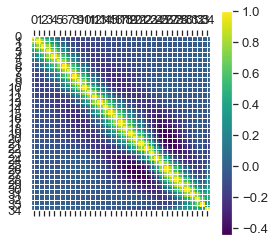

In [167]:
import matplotlib.pyplot as plt
df = pd.DataFrame(data[:,np.s_[900::10]])
plt.matshow(df.corr(),cmap='viridis')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

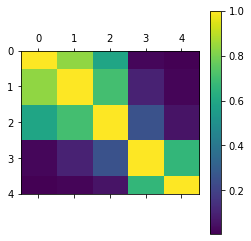

In [9]:
import matplotlib.pyplot as plt
df = pd.DataFrame(bd)
plt.matshow(df.corr(),cmap='viridis')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

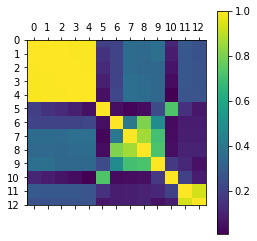

In [11]:
import matplotlib.pyplot as plt
df = pd.DataFrame(res)
plt.matshow(abs(df.corr()),cmap='viridis')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

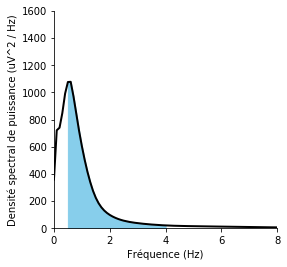

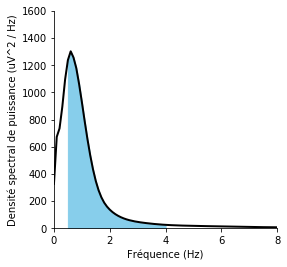

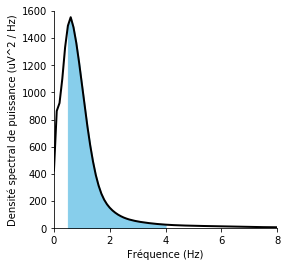

In [206]:
low, high = 0.5, 4
idx_delta = np.logical_and(freqs_mt >= low, freqs_mt <= high)
for j in range(3):
    pp = np.mean(psd_mt[y_data==j,:],axis=0)
    plt.figure(figsize=(4, 4))
    plt.plot(freqs_mt, pp, lw=2, color='k')
    plt.fill_between(freqs_mt, pp, where=idx_delta, color='skyblue')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Densité spectral de puissance (uV^2 / Hz)')
    plt.xlim([0, 8])
    plt.ylim([0, 1600])
    sns.despine()

## Partie 3 - Implémentation des algortihmes

Nous allons tout d'abord tester l'algortihme Random Forest non-ajusté et ajusté. Par la suite, chacun des algorithmes présentés ci-dessous a été utlisé pour sélectionner in fine le meilleur algorithme dans l'objectif d'ajuster celui-ci et d'améliorer ses performances. Pour lister les différentes méthodes, nous avons testé : Random Forest, ANN, SVM, Régression Logistique, Gradient Boosting, Adaptative Boosting, kNN, XGBoost, méthode de Stacking et Light GBM.

In [18]:
### 1 - RandomForest non-ajusté
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
clf = RandomForestClassifier(n_jobs=-1,oob_score=True)
clf.fit(x_train, y_train)
tmps2=time.time()-tmps1
print(clf.oob_score_) # 0.4464351407263016
print(clf.score(x_test,y_test)) # 0.4710761174919258
print(tmps2) # 34.93818497657776 secondes


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.4464351407263016
0.4710761174919258
34.93818497657776


In [17]:
### 1 - RandomForest ajusté
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
clf = RandomForestClassifier(n_estimators=150,n_jobs=-1,oob_score=True)
clf.fit(x_train, y_train)
tmps2=time.time()-tmps1
print(clf.oob_score_) # 0.5062468049324677
print(clf.score(x_test,y_test)) # 0.513348749211688
print(tmps2) # 357.7416250705719 secondes


0.5062468049324677
0.513348749211688
357.7416250705719


In [ ]:
### 2 - ANN non-ajusté
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import initializers
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
model = Sequential()
N = x_train.shape[1]
hidden_size = 2*x_train.shape[1]
model.add(Dense(hidden_size,input_dim=N, kernel_initializer=initializers.glorot_uniform()))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(hidden_size,kernel_initializer=initializers.glorot_uniform()))
model.add(Activation('relu'))
model.add(Dense(1,kernel_initializer=initializers.glorot_uniform()))
model.add(Activation("softmax"))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, verbose=0) #, verbose=0

model.evaluate(x_test,y_test) #score: 0.29911900166262156

In [ ]:
### 3 - Linear Support Vector Machine (SVM) non-ajusté
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
svc = Pipeline([("scaler", StandardScaler()), ("linear_svc", LinearSVC(C=1, loss="hinge"))])
svc.fit(x_train,y_train)

svc.score(x_test,y_test)

In [ ]:
### 4 - Régression Logistique non-ajusté
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
lr = LogisticRegression(C=1, n_jobs=-1)
lr.fit(x_train,y_train)

lr.score(x_test,y_test) # 0.4992642421694345

In [ ]:
### 5 - Gradient Boosting non-ajusté
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1, y_data, test_size=0.2, random_state=33)
xgb = GradientBoostingClassifier(verbose=1)
xgb.fit(x_train,y_train)

xgb.score(x_test,y_test) # 0.5075773501251744

In [ ]:
### 6 - Adaptative Boosting non-ajusté (AdaBoost)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1[:,:(1029-13)], y_data, test_size=0.2, random_state=33)
abc = AdaBoostClassifier()
abc.fit(x_train,y_train)

xgb.score(x_test,y_test) # 0.5075773501251744

In [ ]:
### 7 - K plus proches voisins non-ajusté (kNN)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1) # plus on augmente n_neighbors, plus le score augmente.
knn.fit(x_train1, y_train1)

knn.score(x_test1,y_test) # 0.4688783992967302 (n_neighbors=2000)

Le prochain algorithme est XGBoost, il est l'un des meilleurs algorithmes de Machine Learning due à son amélioration des méthodes de gradient boosting. Par ailleurs, il possède quelques particularités comme le traitement automatiquement des valeurs manquantes. 

In [13]:
### 8 - Extreme Gradient Boosting non-ajusté (XGBoost)
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1, y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
import xgboost as xgb
xgb1 = xgb.XGBClassifier(n_jobs=-1)
xgb1.fit(x_train, y_train)
tmps2=time.time()-tmps1

print(xgb1.score(x_test,y_test)) # 0.5284461176830317
print(tmps2) # 1425.515818119049

0.5284461176830317
1425.515818119049


In [146]:
### 8 - Extreme Gradient Boosting ajusté
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(data1, y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
import xgboost as xgb
xgb1 = xgb.XGBClassifier(learning_rate=0.101, n_estimators=150, n_jobs=-1)
xgb1.fit(x_train, y_train)
tmps2=time.time()-tmps1

print(xgb1.score(x_test,y_test)) # 0.5298794121581593
print(tmps2) # 2439.15

0.5298794121581593
2439.148138999939


Grâce au graphique suivant, nous pouvons détecter les variables les plus importantes dans notre modèle. Ici, il apparaît clairement que la variable 357 joue un rôle prépondérant dans la division des branches des arches de XGBoost. En effet, la variables 357 a un F-score de 321, tandise que la deuxième variables la plus importante a un F-score de 131. 
Le F-score est la moyenne harmonique de la qualité discriminante de la variable. En d'autres termes, c'est le nombre de fois que la variable apparaît dans les noeuds divisé par la somme de ses contributions inverse (l'inverse du coût gagné) à chaque noeuds où elle est présente. On peut aussi la voir comme une fonction de la précision et du rappel :
$$\text{F-score} = 2 \cdot \frac{ (\text{précision} \cdot \text{rappel})}{(\text{précision} + \text{rappel})}$$

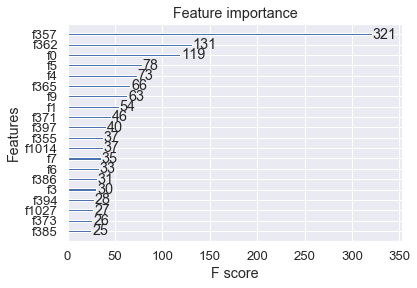

In [240]:
import xgboost as xgb
xgb.plot_importance(xgb1,max_num_features=20)

La figure ci-dessous est le 101ème arbre (arbre 100) pris parmis les arbres composant notre modèle XGBoost. Nous remarquons que la variable 357 est présente dans cet arbre à deux reprises. Nous pouvons voir également que la forme des arbres est toujours la même avec 3 étages de noeuds et aucun noeuds terminaux précoces (avant le dernière étage).

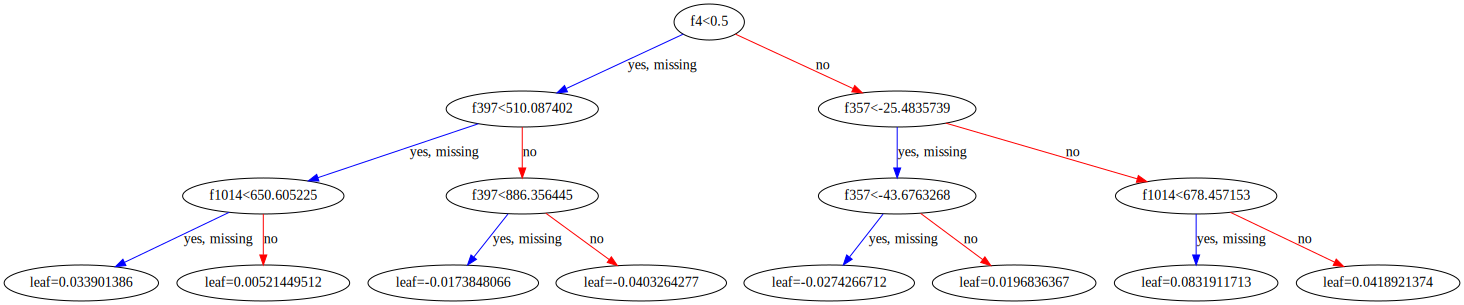

In [255]:
import xgboost as xgb
xgb.to_graphviz(xgb1, num_trees=0)

Dans notre recherche du meilleur modèle, nous avons utilisé des méthodes ensemblistes "manuelles", dites de Stacking, à plusieurs reprises pour agréger le meilleurs de chaque modèle, ou plutôt la compréhension fine de certains aspects des données propres à chaque algorithme. Néanmoins, ces méthodes n'ont pas été concluente dans notre cas et ceci sans doute du fait que peu importe les algorithmes choisies pour le Stacking, aucun n'avait une compréhension clairement différentes des données. Certains algorithmes du Stacking avaient seulement une compréhension plus précise/discriminante.

In [ ]:
### 9 - Méthode ensembliste non-ajustée
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

def Stacking(model,train,y,test,n_fold):
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True)
    test_pred = np.empty((0,1),float)
    train_pred = np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val = train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val = y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred = np.append(train_pred,model.predict(x_val))
    model.fit(X=train,y=y)
    test_pred = np.append(test_pred,model.predict(test))
    return test_pred.reshape(-1,1),train_pred

model1 = RandomForestClassifier(n_estimators=50,n_jobs=-1)
test_pred1, train_pred1 = Stacking(model=model1, n_fold=10, train=pd.DataFrame(x_train), test=x_test, y=pd.DataFrame(y_train))
train_pred1 = pd.DataFrame(train_pred1)
test_pred1 = pd.DataFrame(test_pred1)

model2 = KNeighborsClassifier()
test_pred2, train_pred2 = Stacking(model=model2, n_fold=10, train=pd.DataFrame(x_train), test=x_test, y=pd.DataFrame(y_train))
train_pred2 = pd.DataFrame(train_pred2)
test_pred2 = pd.DataFrame(test_pred2)

model3 = AdaBoostClassifier(n_estimators=50)
test_pred3, train_pred3 = Stacking(model=model3, n_fold=10, train=pd.DataFrame(x_train), test=x_test, y=pd.DataFrame(y_train))
train_pred3 = pd.DataFrame(train_pred3)
test_pred3 = pd.DataFrame(test_pred3)

model4 = LogisticRegression()
test_pred4, train_pred4 = Stacking(model=model4, n_fold=10, train=pd.DataFrame(x_train), test=x_test, y=pd.DataFrame(y_train))
train_pred4 = pd.DataFrame(train_pred4)
test_pred4 = pd.DataFrame(test_pred4)

df = pd.concat([train_pred1, train_pred2, train_pred3, train_pred4], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3, test_pred4], axis=1)

model = LogisticRegression()
model.fit(pd.concat([pd.DataFrame(x_train),df],axis=1), y_train)
model.score(pd.concat([pd.DataFrame(x_test),df_test],axis=1), y_test) # 0.4990922468324192


Nous arrivons donc à la méthode Light GBM qui est elle-même une amélioration de l'algorithme XGBoost. Light GBM impose notamment une plus grande emprise de l'aléatoire sur la construction des arbres à travers les noeuds terminaux par exemple. En effet, cet ajout augmente le biais mais diminue la variance ce qui limite le sur-apprentissage. Cet algorithme est aussi beaucoup plus rapide grâce aux améliorations et simplifications apportées et ce sans sacrifier ses meilleurs résultats.

In [51]:
### 10 - Light Gradient Boosting machine non-ajustée
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(data1, y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
import lightgbm as lgb
lgb1 = lgb.LGBMClassifier(n_jobs=-1)
lgb1.fit(x_train1,y_train1)
tmps2=time.time()-tmps1

print(lgb1.score(x_test1,y_test1))
print(tmps2)

0.5322300150973684
118.00423097610474


In [52]:
### 10 - Light Gradient Boosting machine ajustée
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(data1, y_data, test_size=0.2, random_state=33)
import time 
tmps1=time.time()
import lightgbm as lgb
lgb1 = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=182, random_state=33, n_jobs=-1, max_depth=22)
lgb1.fit(x_train1,y_train1)
tmps2=time.time()-tmps1

print(lgb1.score(x_test1,y_test1))
print(tmps2)

0.5309304947732528
160.15909719467163


Dans le but d'implémenter et d'ajuster l'algorithme Light GBM, nous pouvons utiliser l'importance des variables calculée par le nombre d'apparition de la variables dans les partages des arbres créés. Ici, nous remarquons que c'est la variables 357 (la dernière valeurs de l'EEG) qui est la variable la plus importante. Par ailleurs, nous avons comme pour XGBoost un grand écart entre la variable 357 et les autres variables (bien que les mesures diffèrent).

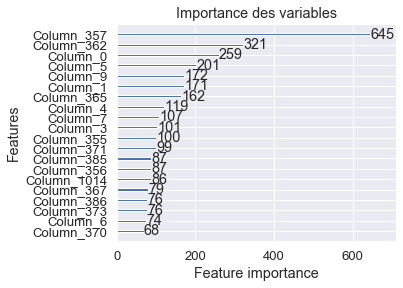

In [284]:
import lightgbm as lgb
rcParams['figure.figsize'] = 5,4
lgb.plot_importance(lgb1,max_num_features=20,title='Importance des variables')

Dans le graphique suivant, nous pouvons observer la fréquence des valeurs de partage des noeuds (split) de la variables 357 dans les arbres du modèle créé. Cela nous permet de connaître les valeurs fortement discriminantes de la variables la plus importante dans les arbres du modèle.

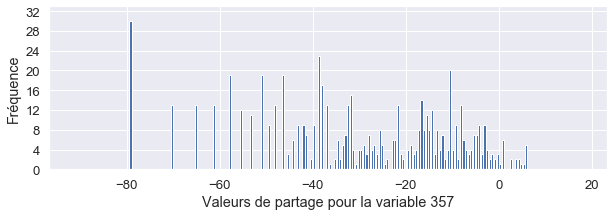

In [287]:
rcParams['figure.figsize'] = 10,3
lgb.plot_split_value_histogram(lgb1,357,title='',
                              ylabel='Fréquence',xlabel='Valeurs de partage pour la variable 357')

Nous trouvons ci-dessous le permier arbre construit dans notre modèle Light GBM. Nous remarquons bien ici que les noeuds terminaux n'ont pas tous la même profondeur comme nous le disions précédement. La variables 357 est également présente dans cet arbre à 6 reprises.

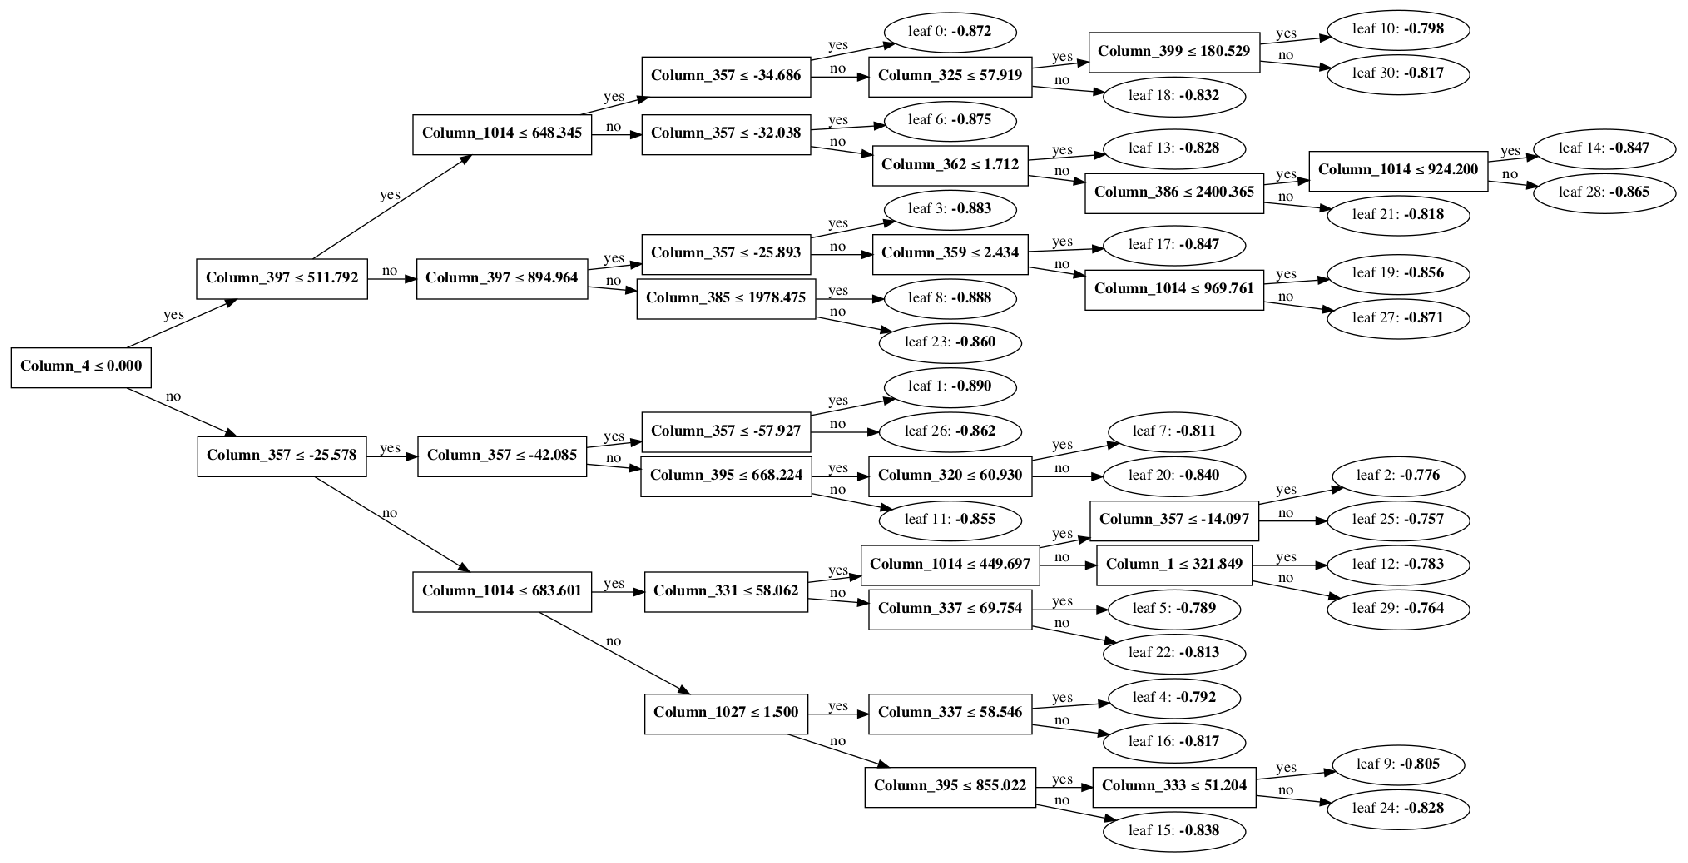

In [173]:
lgb.plot_tree(lgb1, figsize=(30,30), tree_index=0)

Fort de ces informations sur notre modèle, nous avons tenté d'améliorer celui-ci en supprimant des variables qui étaient les moins importantes. Cependant, nous avons remarqué que la suppression de variables, même très corrélées avec d'autres variables, détériorait la qualité prédictive du modèle et qu'au contraire l'ajout de variables augmentait la qualité du modèle. De même, la suppression d'individus outliers a eu le même effet.

Par ailleurs, nous avons fixé un l'alea (random_state=33) pour améliorer et ajuster plus efficacement notre modèle Light GBM.

## Partie 4 - Analyse du meilleur modèle

Nous avons après avoir ajusté du mieux que nous le pouvions notre modèle et gardé celui qui obtenait le meilleur score au Data Challenge, nous avons réalisé une analyse de nos résultats et de la qualité prédictive de notre modèle.
Il se trouve qu'à travers nos résultats proche de 53% de bonnes prédictions, nous ne nous attendions pas à une compréhension fine de notre modèle sur les différences de nos 3 labels. En revanche, nous avons été surpris que l'algorithme ne dissocie pas les différences entre l'absence de faible oscillation et la présence de faibles oscillations, ou bien les faibles oscillations de basse et hautes amplitudes. Comme nous pouvons le voir sur la matrice de confusion, l'algorithme tend à prévoir le label 0 car c'est le label le plus présent dans nos jeux de données train et test et qu'il ne détecte pas de structure sous-jacente aux données qui lui permettraient de discriminer avec suffisament de certitude les données. Ainsi, il détecte des informations qui lui permettent de discriminer suffisament pour obtenir des résultats (53%) suppérieur au hasard (environs 33%) ou au fait de ne prédire que le label 0 (environs 44%).

In [195]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test1, lgb1.predict(x_test1)))
row_sums = confusion_matrix(y_test1, lgb1.predict(x_test1)).sum(axis=1)
print(np.round(confusion_matrix(y_test1, lgb1.predict(x_test1)) / row_sums[:, np.newaxis],3))

[[17780  3338  1552]
 [ 6891  5538  3339]
 [ 4950  4475  4464]]
[[0.784 0.147 0.068]
 [0.437 0.351 0.212]
 [0.356 0.322 0.321]]


Le graphique suivant représente les courbes ROC (Receiver Operating Characteristic ou caractéristique de fonctionnement du récepteur) des 3 labels calculées sur un seul train-test. Le label 0 est celui qui est le mieux classé car il a le plus fort AUC (Area Under the Curve ou aire sous la courbe). De plus, la courbe ROC en macro-moyenne et la courbre micro-moyenne nous spécifie que le déséquilibre de la répartition des labels dans les données influence la qualité du classement.

La courbe ROC par macro-moyenne calcul les valeurs indépendament pour chaque classe et en prend la moyenne, tandise que la courbe ROC en micro-moyenne agrège les contributions de toutes les classes pour obtenir la valeurs moyenne.

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from scipy import interp

X = data1
y = y_data

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y_data, test_size=0.2, random_state=33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Learn to predict each class against the other
classifier = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=182, random_state=33, n_jobs=-1, max_depth=22)
classifier.fit(X_train_data, y_train_data)
y_score = np.zeros((y_test.shape[0],3))
y_score[np.where(classifier.predict(X_test_data)==0)[0],0] = 1; y_score[np.where(classifier.predict(X_test_data)==1)[0],1] = 1; y_score[np.where(classifier.predict(X_test_data)==2)[0],2] = 1

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


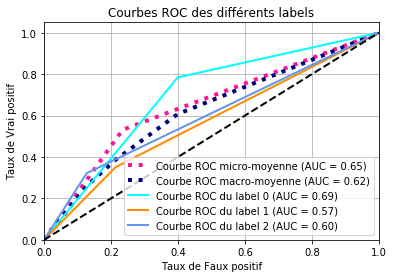

In [222]:
import matplotlib.pyplot as plt
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
lw = 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],label='Courbe ROC micro-moyenne (AUC = {0:0.2f})'''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],label='Courbe ROC macro-moyenne (AUC = {0:0.2f})'''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Courbe ROC du label {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid()
plt.xlabel('Taux de Faux positif')
plt.ylabel('Taux de Vrai positif')
plt.title('Courbes ROC des différents labels')
plt.legend(loc="lower right")
plt.show()

In [225]:
#Receiver Operating Characteristic (ROC) avec validation croisée
def ROC_plot(j):
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import label_binarize
    import lightgbm as lgb
    from sklearn.metrics import roc_curve, auc
    from sklearn.model_selection import StratifiedKFold

    X = data1
    y = y_data
    y = label_binarize(y, classes=[0, 1, 2])[:,j]
    cv = StratifiedKFold(n_splits=4)
    #classifier = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=182, n_jobs=-1, max_depth=22)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        classifier = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=182, n_jobs=-1, max_depth=22)
        probas_ = classifier.fit(X[train], y_data[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:,j])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Hasard', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',label=r'ROC moyen (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 écart-type')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Taux de Faux positif')
    plt.ylabel('Taux de Vrai positif')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

Grâce à la fonction ci-dessus (ROC_plot), nous obtenons les courbes ROC suivantes. Tout d'abord, nous avons calculé la courbe ROC pour le label 0 sur les 1000 premières données en validation croisée 4-folds. Nous observons que l'AUC est faible en moyenne (0.63) et reste peu déviante de cette moyenne (plus ou moins 0.02).

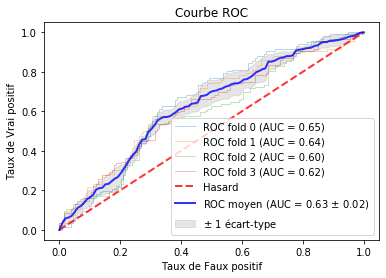

In [224]:
ROC_plot(0) # pour les 1000 premiers individus

En opérant ce processus sur l'entièreté des données, nous obtenons les résultats suivant pour chacun des 3 labels. Les résultats sont similaires aux précédents et montre très clairement un classement intéressant en label 0 (AUC - 0.77) et faible pour les les labels 1 (AUC - 0.65) et 2 (AUC - 0.70).

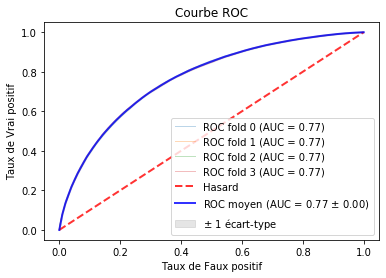

In [226]:
ROC_plot(0)

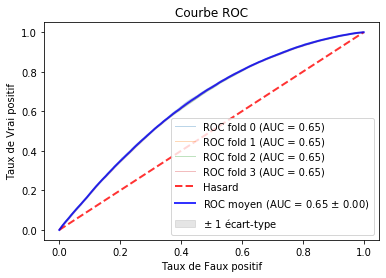

In [227]:
ROC_plot(1)

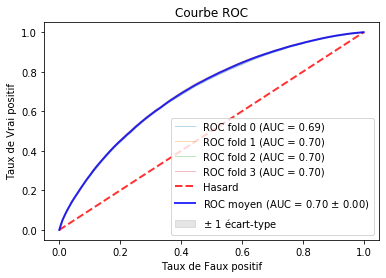

In [228]:
ROC_plot(2)

## Partie 5 - Algorithme Light GBM pour le Test

Dans cette dernière partie, nous présentons les quelques manipulations qui nous ont permis de transformer les données de test dans le format nécessaire à la prédiction.

In [ ]:
res = np.loadtxt('last.csv', delimiter=',')
bd = np.loadtxt('bd.csv', delimiter=',')
data = X_train["features"][:,11:]

In [ ]:
from mne.time_frequency import psd_array_multitaper
sf = 125.
psd_mt, freqs_mt = psd_array_multitaper(data,sf,adaptive=True,normalization='full',n_jobs=8)

In [ ]:
data1.append(variation(data,1).reshape(-1, 1))
data1.append(variation(data[:,850:],1).reshape(-1, 1))
data1.append(variation(data[:,500:850],1).reshape(-1, 1))
data1.append(variation(data[:,:500],1).reshape(-1, 1))
data1.append(data[:,850:].mean(1).reshape(-1, 1))
data1.append(data[:,500:850].mean(1).reshape(-1, 1))
data1.append(data[:,:500].mean(1).reshape(-1, 1))
data1.append(data.mean(1).reshape(-1, 1))
data1.append(data.var(1).reshape(-1, 1))
data1.append(data[:,850:].var(1).reshape(-1, 1))
data1.append(data[:,500:850].var(1).reshape(-1, 1))
data1.append(data[:,:500].var(1).reshape(-1, 1))

data1.append(data.max(1).reshape(-1, 1))
data1.append(data.min(1).reshape(-1, 1))
data1.append(np.median(data,1).reshape(-1, 1))
data1.append(data[:,850:].max(1).reshape(-1, 1))
data1.append(data[:,500:850].max(1).reshape(-1, 1))
data1.append(data[:,:500].max(1).reshape(-1, 1))
data1.append(data[:,850:].min(1).reshape(-1, 1))
data1.append(data[:,500:850].min(1).reshape(-1, 1))
data1.append(data[:,:500].min(1).reshape(-1, 1))
data1.append(np.median(data[:,850:],1).reshape(-1, 1))
data1.append(np.median(data[:,500:850],1).reshape(-1, 1))
data1.append(np.median(data[:,:500],1).reshape(-1, 1))

#data1.append(stats.mode(data.astype(int),1)[0].reshape(-1, 1))
#data1.append(stats.mode(data[:,9850:].astype(int),1)[0].reshape(-1, 1))
#data1.append(stats.mode(data[:,500:850].astype(int),1)[0].reshape(-1, 1))
#data1.append(stats.mode(data[:,:500].astype(int),1)[0].reshape(-1, 1))


In [ ]:
data1.append(psd_mt.max(1).reshape(-1, 1)) #

#data1.append(bd.max(1).reshape(-1, 1)) #
#data1.append(bd.min(1).reshape(-1, 1)) #
data1.append(bd.mean(1).reshape(-1, 1)) 
data1.append(bd.var(1).reshape(-1, 1)) 
np.where(bd==bd.max(1).reshape(-1,1))[1].reshape(-1,1)
np.where(bd==bd.min(1).reshape(-1,1))[1].reshape(-1,1)

#data1.append(iqr(data,1).reshape(-1, 1))
#data1.append(iqr(data[:,850:],1).reshape(-1, 1))
#data1.append(iqr(data[:,500:850],1).reshape(-1, 1))
#data1.append(iqr(data[:,:500],1).reshape(-1, 1))

#bdm = np.copy(bd)
#for i in range(bd.shape[1]):
#    bdm[:,i] = bd[:,i]/bd.sum(1)
#data1.append(bdm)

#data1.append(psd)
data1.append(psd_mt)
data1.append(bd)
#data1.append((bd[:,3]/bd[:,0]).reshape(-1, 1))
data1.append(res)

data1 = np.concatenate(data1,1)#[:,ind_sup]


In [ ]:
y_pred = lgb1.predict(data1)
with open("y_benchmark.csv", "w") as f:
    f.write("".join(["id,label\n"] + ["{},{}\n".format(i, y) for i, y in enumerate(y_pred)]))


## Conclusion

A travers les différentes manipulations que nous avons pu effectuer, nous avons pu repérer les différentes caractéristiques de ce jeu de données, sélectionner une méthode algorithmique parmi divers algorithmes de Machine Learning et ajuster un modèle final dans l'objectif d'obtenir toujours les meilleurs prédictions. Grâce au cheminement que nous venons de vous présenter, notre score final est de 0.5338 au Data Challenge 2019 en se plaçant actuellement (2 décembre 2019) à la 3ème place de ce classement.